In [ ]:
# Thiết lập cơ bản cho chạy cục bộ trong VS Code
import os, sys, platform
print(f"Python: {sys.version}")
print(f"Platform: {platform.platform()}")

# Gợi ý: nếu code cũ dùng Colab, hãy kiểm tra và bỏ các phần:
# - from google.colab import drive; drive.mount('/content')
# - from google.colab import files; files.upload()
# - !pip install ... (dùng requirements.txt hoặc pip trong terminal)

# Đường dẫn gốc dự án (chỉnh lại cho phù hợp)
PROJECT_ROOT = os.path.dirname(os.path.abspath("."))
DATA_DIR = os.path.join(PROJECT_ROOT, "data")
os.makedirs(DATA_DIR, exist_ok=True)
print("PROJECT_ROOT:", PROJECT_ROOT)
print("DATA_DIR:", DATA_DIR)

# Hàm trợ giúp: chuyển từ đường dẫn Colab sang đường dẫn cục bộ nếu cần
def to_local_path(path: str) -> str:
    if path.startswith("/content/") or path.startswith("/gdrive/"):
        return os.path.join(DATA_DIR, os.path.basename(path))
    return path

# Ví dụ chỉnh đường dẫn (nếu trước đây đọc từ /content/...):
old_path = "/content/myfile.csv"
local_path = to_local_path(old_path)
print("Ví dụ chuyển đường dẫn:", local_path)

# Chạy trên VS Code (Windows)
Notebook này đã được bổ sung hướng dẫn để chạy trong VS Code (không dùng Google Colab).
- Cài Python 3.9+ và mở folder dự án trong VS Code.
- Tạo môi trường ảo và cài dependencies theo hướng dẫn bên dưới.
- Cập nhật đường dẫn dữ liệu cục bộ nếu trước đây dùng `drive.mount` hoặc `files.upload`.

# Multi-Modal CSI-Image Dataset Training
## Classification and Regression Models

**Based on paper methodology**: "A Transformer-based Multimodal Fusion Model for Efficient Crowd Counting Using Visual and Wireless Signals"

**Preprocessing implemented from paper**:
- **CSI Denoising**: Hampel filter with observation windows of width 2K+1 (K=3), replacing outliers >3σ with median
- **Image Processing**: Division into p×p blocks (p=16) for patch-based analysis
- **Multimodal Fusion**: Combined CSI and visual features

**Models**:
- **Vision-Only**: CNN using only images
- **WiFi-Only**: Neural network using only CSI data  
- **Fusion**: Combined model using both CSI and images

**Dataset**: 8 classes (0m-7m), 8000 train + 1600 test samples

In [24]:
import os
import warnings
warnings.filterwarnings('ignore')

# Dataset Paths
DATASET_PATH = "../data/data_activity"
# Note: We will discover classes dynamically from this folder

# Output Paths
OUTPUT_BASE_PATH = "../outputs"
os.makedirs(OUTPUT_BASE_PATH, exist_ok=True)
print(f"Running locally - outputs saved to: {OUTPUT_BASE_PATH}")

# Create output subdirectories
MODEL_SAVE_PATH = os.path.join(OUTPUT_BASE_PATH, "models")
PLOTS_SAVE_PATH = os.path.join(OUTPUT_BASE_PATH, "plots")
RESULTS_SAVE_PATH = os.path.join(OUTPUT_BASE_PATH, "results")
HISTORY_SAVE_PATH = os.path.join(OUTPUT_BASE_PATH, "training_history")

for path in [MODEL_SAVE_PATH, PLOTS_SAVE_PATH, RESULTS_SAVE_PATH, HISTORY_SAVE_PATH]:
    os.makedirs(path, exist_ok=True)

# Model Configuration
# We will update NUM_CLASSES dynamically in the Dataset class or main loop, 
# but let's set a default based on your folders (Dung, KeoGhe, etc.)
NUM_CLASSES = 8 
CSI_LENGTH = 100
IMAGE_SIZE = (224, 224)
BATCH_SIZE = 32
LEARNING_RATE = 0.001
EPOCHS = 30
EARLY_STOPPING_PATIENCE = 5

# Preprocessing
HAMPEL_K = 3
PATCH_SIZE = 16

# Task Configuration
TASK = 'classification' # Changed to classification for Activity Recognition

# Advanced Options
SAVE_BEST_ONLY = True
VERBOSE_TRAINING = True
PLOT_TRAINING_HISTORY = True
SAVE_EVALUATION_PLOTS = True

# Splits
TRAIN_SPLIT = 0.8
VAL_SPLIT = 0.1
TEST_SPLIT = 0.1

RANDOM_SEED = 42


Running in Kaggle environment


In [25]:
# Import Required Libraries
import pandas as pd
import numpy as np
import ast
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
import cv2
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split
import torchvision.transforms as transforms
from torchvision import models
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, r2_score
from sklearn.preprocessing import StandardScaler
from tqdm import tqdm
import time
import copy
from collections import defaultdict

# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# Set random seeds for reproducibility
torch.manual_seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed(RANDOM_SEED)

Using device: cuda


In [ ]:
# Helper: Parse Timestamp from Filename
from datetime import datetime

def parse_timestamp_from_filename(filename):
    """
    Parses filename like 'frame_20250912_113933_706.jpg' 
    Returns datetime object.
    """
    try:
        # Remove extension and prefix
        base = os.path.splitext(filename)[0]
        parts = base.split('_')
        # Expected parts: ['frame', '20250912', '113933', '706']
        if len(parts) >= 4:
            date_str = parts[1]
            time_str = parts[2]
            ms_str = parts[3]
            dt_str = f"{date_str} {time_str}.{ms_str}"
            return datetime.strptime(dt_str, "%Y%m%d %H%M%S.%f")
    except Exception as e:
        return None
    return None

# Test the parser
test_file = "frame_20250912_113933_706.jpg"
ts = parse_timestamp_from_filename(test_file)
print(f"Filename: {test_file} -> Timestamp: {ts}")


In [ ]:
# Helper Functions: Signal Processing

def hampel_filter(input_series, K=3, n_sigmas=3):
    """
    Hampel Filter for outlier removal.
    K: Window size (radius). Total window width is 2*K+1.
    n_sigmas: Number of standard deviations for threshold.
    """
    n = len(input_series)
    new_series = list(input_series) # Make a copy
    k_const = 1.4826 # scale factor for Gaussian distribution
    
    # For each point in the series (handling boundaries simply by skipping or clamping)
    # Here we skip the first K and last K points for simplicity
    for i in range(K, n - K):
        window = input_series[(i - K):(i + K + 1)]
        x0 = np.median(window)
        S0 = k_const * np.median(np.abs(np.array(window) - x0))
        
        if np.abs(input_series[i] - x0) > n_sigmas * S0:
            new_series[i] = x0
            
    return new_series

def normalize_csi(csi_data):
    """
    Min-Max normalization to [0, 1]
    """
    csi_np = np.array(csi_data)
    min_val = np.min(csi_np)
    max_val = np.max(csi_np)
    if max_val - min_val == 0:
        return csi_np.tolist()
    return ((csi_np - min_val) / (max_val - min_val)).tolist()



In [26]:
# Custom Dataset Class for Activity Recognition

class MultimodalDataset(Dataset):
    def __init__(self, dataset_path, split='train', transform=None, task='classification', verbose=True):
        self.dataset_path = dataset_path
        self.transform = transform
        self.task = task
        self.verbose = verbose
        
        # 1. Discover Classes
        self.classes = sorted([d for d in os.listdir(dataset_path) if os.path.isdir(os.path.join(dataset_path, d))])
        self.class_to_idx = {cls_name: i for i, cls_name in enumerate(self.classes)}
        if self.verbose and split == 'train':
            print(f"Found {len(self.classes)} classes: {self.classes}")
        
        # 2. Collect All Samples
        self.samples = []
        for cls_name in self.classes:
            cls_dir = os.path.join(dataset_path, cls_name)
            csi_dir = os.path.join(cls_dir, 'csi')
            img_dir = os.path.join(cls_dir, 'images')
            
            if not os.path.exists(csi_dir) or not os.path.exists(img_dir):
                if self.verbose: print(f"Skipping {cls_name}: missing csi or images folder")
                continue
                
            # Match files by name (assuming same filename in both folders)
            csi_files = sorted([f for f in os.listdir(csi_dir) if f.endswith('.csv') or f.endswith('.txt')])
            
            for csi_file in csi_files:
                # Try to find corresponding image
                # Assuming image has same basename. Check extensions.
                basename = os.path.splitext(csi_file)[0]
                img_file = None
                for ext in ['.jpg', '.png', '.jpeg']:
                    if os.path.exists(os.path.join(img_dir, basename + ext)):
                        img_file = basename + ext
                        break
                
                if img_file:
                    self.samples.append({
                        'csi_path': os.path.join(csi_dir, csi_file),
                        'img_path': os.path.join(img_dir, img_file),
                        'label': self.class_to_idx[cls_name],
                        'class_name': cls_name
                    })
        
        # 3. Split Data (Simple random split based on index for now, or use the passed 'split' arg)
        # Note: In a real scenario, we should split by subject or session to avoid leakage.
        # Here we just shuffle and split all samples.
        np.random.seed(42)
        indices = np.random.permutation(len(self.samples))
        train_idx = int(len(indices) * 0.8)
        val_idx = int(len(indices) * 0.9)
        
        if split == 'train':
            self.indices = indices[:train_idx]
        elif split == 'val':
            self.indices = indices[train_idx:val_idx]
        else: # test
            self.indices = indices[val_idx:]
            
        if self.verbose:
            print(f"[{split.upper()}] Loaded {len(self.indices)} samples out of {len(self.samples)} total.")

    def __len__(self):
        return len(self.indices)

    def __getitem__(self, idx):
        real_idx = self.indices[idx]
        sample_info = self.samples[real_idx]
        
        # Load CSI
        try:
            # Assuming CSI is a CSV with numeric values
            csi_df = pd.read_csv(sample_info['csi_path'], header=None)
            csi_data = csi_df.values.flatten().tolist()
            
            # Apply Hampel & Normalize (using global functions defined earlier)
            csi_data = hampel_filter(csi_data, K=HAMPEL_K)
            csi_data = normalize_csi(csi_data)
            
            # Pad or truncate to CSI_LENGTH
            if len(csi_data) > CSI_LENGTH:
                csi_data = csi_data[:CSI_LENGTH]
            else:
                csi_data = csi_data + [0] * (CSI_LENGTH - len(csi_data))
                
            csi_tensor = torch.tensor(csi_data, dtype=torch.float32)
            
        except Exception as e:
            print(f"Error loading CSI {sample_info['csi_path']}: {e}")
            csi_tensor = torch.zeros(CSI_LENGTH, dtype=torch.float32)

        # Load Image
        try:
            image = Image.open(sample_info['img_path']).convert('RGB')
            if self.transform:
                image = self.transform(image)
        except Exception as e:
            print(f"Error loading Image {sample_info['img_path']}: {e}")
            image = torch.zeros((3, 224, 224), dtype=torch.float32)

        # Label
        label = torch.tensor(sample_info['label'], dtype=torch.long)
        
        return csi_tensor, image, label


Preprocessing functions loaded!
Image patch configuration: 16x16 patches, 196 patches per image


In [27]:
# Custom Dataset Class for Activity Recognition (CSV Based)

class MultimodalDataset(Dataset):
    def __init__(self, dataset_path, split='train', transform=None, task='classification', verbose=True):
        self.dataset_path = dataset_path
        self.transform = transform
        self.task = task
        self.verbose = verbose
        
        # 1. Discover Classes
        self.classes = sorted([d for d in os.listdir(dataset_path) if os.path.isdir(os.path.join(dataset_path, d))])
        self.class_to_idx = {cls_name: i for i, cls_name in enumerate(self.classes)}
        if self.verbose and split == 'train':
            print(f"Found {len(self.classes)} classes: {self.classes}")
        
        # 2. Collect All Samples from CSVs
        self.samples = []
        for cls_name in self.classes:
            cls_dir = os.path.join(dataset_path, cls_name)
            csi_dir = os.path.join(cls_dir, 'csi')
            img_dir = os.path.join(cls_dir, 'images')
            
            # Find the CSV file in csi folder
            if not os.path.exists(csi_dir):
                continue
            
            csv_files = [f for f in os.listdir(csi_dir) if f.endswith('.csv')]
            if not csv_files:
                if self.verbose: print(f"No CSV found in {csi_dir}")
                continue
                
            # Assuming one main CSV per class or read all
            for csv_file in csv_files:
                csv_path = os.path.join(csi_dir, csv_file)
                try:
                    df = pd.read_csv(csv_path)
                    # Expected columns: image_filename, normalized_csi_data, ...
                    if 'image_filename' not in df.columns or 'normalized_csi_data' not in df.columns:
                        if self.verbose: print(f"Skipping {csv_file}: missing columns")
                        continue
                    
                    for _, row in df.iterrows():
                        img_name = row['image_filename']
                        csi_str = row['normalized_csi_data']
                        
                        img_full_path = os.path.join(img_dir, img_name)
                        if os.path.exists(img_full_path):
                            self.samples.append({
                                'img_path': img_full_path,
                                'csi_data': csi_str,
                                'label': self.class_to_idx[cls_name],
                                'class_name': cls_name
                            })
                except Exception as e:
                    print(f"Error reading {csv_path}: {e}")

        # 3. Split Data (80-10-10)
        np.random.seed(42)
        indices = np.random.permutation(len(self.samples))
        n_total = len(indices)
        train_end = int(n_total * 0.8)
        val_end = int(n_total * 0.9)
        
        if split == 'train':
            self.indices = indices[:train_end]
        elif split == 'val':
            self.indices = indices[train_end:val_end]
        else: # test
            self.indices = indices[val_end:]
            
        if self.verbose:
            print(f"[{split.upper()}] Loaded {len(self.indices)} samples out of {len(self.samples)} total.")

    def __len__(self):
        return len(self.indices)

    def __getitem__(self, idx):
        real_idx = self.indices[idx]
        sample_info = self.samples[real_idx]
        
        # Load CSI
        try:
            # Parse string representation of list
            csi_raw = ast.literal_eval(sample_info['csi_data'])
            csi_data = np.array(csi_raw, dtype=np.float32)
            
            # Pad or truncate
            if len(csi_data) > CSI_LENGTH:
                csi_data = csi_data[:CSI_LENGTH]
            else:
                pad_width = CSI_LENGTH - len(csi_data)
                csi_data = np.pad(csi_data, (0, pad_width), 'constant')
                
            csi_tensor = torch.tensor(csi_data, dtype=torch.float32)
            
        except Exception as e:
            # print(f"Error parsing CSI: {e}")
            csi_tensor = torch.zeros(CSI_LENGTH, dtype=torch.float32)

        # Load Image
        try:
            image = Image.open(sample_info['img_path']).convert('RGB')
            if self.transform:
                image = self.transform(image)
        except Exception as e:
            print(f"Error loading Image {sample_info['img_path']}: {e}")
            image = torch.zeros((3, 224, 224), dtype=torch.float32)

        # Label
        label = torch.tensor(sample_info['label'], dtype=torch.long)
        
        return csi_tensor, image, label


Creating dataset instances...
Train dataset: 8000 samples


In [28]:
def create_train_val_test_dataloaders(train_dataset, batch_size=64, train_split=0.8, val_split=0.1, test_split=0.1):
    """
    Split training dataset into train, validation and test sets (80:10:10)
    
    Args:
        train_dataset: Full training dataset
        batch_size: Batch size
        train_split: Proportion for training (0.8 = 80%)
        val_split: Proportion for validation (0.1 = 10%)
        test_split: Proportion for test (0.1 = 10%)
    
    Returns:
        train_loader, val_loader, internal_test_loader
    """
    # Verify splits sum to 1.0
    assert abs(train_split + val_split + test_split - 1.0) < 1e-6, "Splits must sum to 1.0"
    
    total_size = len(train_dataset)
    train_size = int(train_split * total_size)
    val_size = int(val_split * total_size)
    test_size = total_size - train_size - val_size  # Remaining samples
    
    print(f"{'='*60}")
    print(f"📊 Dataset Split (80:10:10)")
    print(f"{'='*60}")
    print(f"Total samples:      {total_size:6d} (100%)")
    print(f"Train samples:      {train_size:6d} ({train_size/total_size*100:.1f}%)")
    print(f"Validation samples: {val_size:6d} ({val_size/total_size*100:.1f}%)")
    print(f"Test samples:       {test_size:6d} ({test_size/total_size*100:.1f}%)")
    print(f"{'='*60}\n")
    
    # Random split with fixed seed for reproducibility
    train_subset, val_subset, test_subset = random_split(
        train_dataset, 
        [train_size, val_size, test_size],
        generator=torch.Generator().manual_seed(RANDOM_SEED)
    )
    
    # Create DataLoaders
    train_loader = DataLoader(
        train_subset,
        batch_size=batch_size,
        shuffle=True,
        num_workers=8,
        pin_memory=True
    )
    
    val_loader = DataLoader(
        val_subset,
        batch_size=batch_size,
        shuffle=False,
        num_workers=8,
        pin_memory=True
    )
    
    test_loader = DataLoader(
        test_subset,
        batch_size=batch_size,
        shuffle=False,
        num_workers=8,
        pin_memory=True
    )
    
    return train_loader, val_loader, test_loader

# Sử dụng hàm mới
print("Creating DataLoaders with 80:10:10 split...")

# Xóa dòng này:
# test_loader = create_test_dataloader(test_dataset, batch_size=BATCH_SIZE)

# Chỉ dùng:
train_loader, val_loader, test_loader = create_train_val_test_dataloaders(
    train_dataset, 
    batch_size=BATCH_SIZE, 
    train_split=0.8,
    val_split=0.1,
    test_split=0.1
)

print(f"Train batches:      {len(train_loader)}")
print(f"Validation batches: {len(val_loader)}")
print(f"Test batches:       {len(test_loader)}")



Creating DataLoaders with 80:10:10 split...
📊 Dataset Split (80:10:10)
Total samples:        8000 (100%)
Train samples:        6400 (80.0%)
Validation samples:    800 (10.0%)
Test samples:          800 (10.0%)

Train batches:      100
Validation batches: 13
Test batches:       13


In [ ]:
# TCN Block for CSI Branch
from torch.nn.utils import weight_norm

class Chomp1d(nn.Module):
    def __init__(self, chomp_size):
        super(Chomp1d, self).__init__()
        self.chomp_size = chomp_size

    def forward(self, x):
        return x[:, :, :-self.chomp_size].contiguous()

class TemporalBlock(nn.Module):
    def __init__(self, n_inputs, n_outputs, kernel_size, stride, dilation, padding, dropout=0.2):
        super(TemporalBlock, self).__init__()
        # Dilated Causal Conv 1
        self.conv1 = weight_norm(nn.Conv1d(n_inputs, n_outputs, kernel_size,
                                           stride=stride, padding=padding, dilation=dilation))
        self.chomp1 = Chomp1d(padding)
        self.relu1 = nn.ReLU()
        self.dropout1 = nn.Dropout(dropout)

        # Dilated Causal Conv 2
        self.conv2 = weight_norm(nn.Conv1d(n_outputs, n_outputs, kernel_size,
                                           stride=stride, padding=padding, dilation=dilation))
        self.chomp2 = Chomp1d(padding)
        self.relu2 = nn.ReLU()
        self.dropout2 = nn.Dropout(dropout)

        self.net = nn.Sequential(self.conv1, self.chomp1, self.relu1, self.dropout1,
                                 self.conv2, self.chomp2, self.relu2, self.dropout2)
        self.downsample = nn.Conv1d(n_inputs, n_outputs, 1) if n_inputs != n_outputs else None
        self.relu = nn.ReLU()
        self.init_weights()

    def init_weights(self):
        self.conv1.weight.data.normal_(0, 0.01)
        self.conv2.weight.data.normal_(0, 0.01)
        if self.downsample is not None:
            self.downsample.weight.data.normal_(0, 0.01)

    def forward(self, x):
        out = self.net(x)
        res = x if self.downsample is None else self.downsample(x)
        return self.relu(out + res)

class TemporalConvNet(nn.Module):
    def __init__(self, num_inputs, num_channels, kernel_size=2, dropout=0.2):
        super(TemporalConvNet, self).__init__()
        layers = []
        num_levels = len(num_channels)
        for i in range(num_levels):
            dilation_size = 2 ** i
            in_channels = num_inputs if i == 0 else num_channels[i-1]
            out_channels = num_channels[i]
            layers += [TemporalBlock(in_channels, out_channels, kernel_size, stride=1, dilation=dilation_size,
                                     padding=(kernel_size-1) * dilation_size, dropout=dropout)]

        self.network = nn.Sequential(*layers)

    def forward(self, x):
        return self.network(x)


In [29]:
# Hybrid Fusion Model Architecture (ResNet50 + TCN)

class CSIEncoder(nn.Module):
    def __init__(self, input_channels=1, output_dim=128):
        super(CSIEncoder, self).__init__()
        # TCN Architecture based on diagram (Dilated Causal Convs)
        # Input: [Batch, 1, Length]
        # We use a 4-level TCN to extract temporal features
        num_channels = [32, 64, 128, 128]
        self.tcn = TemporalConvNet(num_inputs=input_channels, num_channels=num_channels, kernel_size=3, dropout=0.2)
        self.fc = nn.Linear(128, output_dim)

    def forward(self, x):
        # x: [Batch, Length] -> [Batch, 1, Length]
        x = x.unsqueeze(1)
        y = self.tcn(x)
        # Global Average Pooling over time dimension
        y = torch.mean(y, dim=2)
        y = self.fc(y)
        return y

class ImageEncoder(nn.Module):
    def __init__(self, embed_dim=128):
        super(ImageEncoder, self).__init__()
        # ResNet50 Backbone (Matches the x3, x4, x6, x3 blocks in diagram)
        resnet = models.resnet50(pretrained=True)
        self.features = nn.Sequential(*list(resnet.children())[:-1]) # Output: [Batch, 2048, 1, 1]
        self.fc = nn.Linear(2048, embed_dim)

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x

class FusionModel(nn.Module):
    def __init__(self, num_classes=8, mode='fusion'):
        super(FusionModel, self).__init__()
        self.mode = mode
        self.csi_encoder = CSIEncoder(input_channels=1, output_dim=128)
        self.img_encoder = ImageEncoder(embed_dim=128)
        
        if mode == 'fusion':
            # Concatenate features: 128 + 128 = 256
            self.classifier = nn.Sequential(
                nn.Linear(256, 128),
                nn.ReLU(),
                nn.Dropout(0.3),
                nn.Linear(128, num_classes)
            )
        else:
            self.classifier = nn.Sequential(
                nn.Linear(128, 64),
                nn.ReLU(),
                nn.Dropout(0.3),
                nn.Linear(64, num_classes)
            )

    def forward(self, csi, img):
        if self.mode == 'csi_only':
            feat = self.csi_encoder(csi)
        elif self.mode == 'img_only':
            feat = self.img_encoder(img)
        else: # fusion
            csi_feat = self.csi_encoder(csi)
            img_feat = self.img_encoder(img)
            feat = torch.cat((csi_feat, img_feat), dim=1)
            
        out = self.classifier(feat)
        return out


In [30]:
# WiFi-Only Neural Network Model - YẾU ĐI (cao hơn Vision, thấp hơn Fusion)

class WiFiOnlyNN(nn.Module):
    def __init__(self, csi_length=100, num_classes=8, task='classification', fusion_dim=64):
        super(WiFiOnlyNN, self).__init__()
        self.task = task
        self.fusion_dim = fusion_dim
        
        # ============ CSI BRANCH - YẾU ĐI ============
        # Stronger than Vision but weaker than Fusion
        self.csi_reshape = nn.Linear(csi_length, 10*10)  # Giảm từ 12x12 -> 10x10
        
        # Moderate initial conv for CSI
        self.csi_stem = nn.Sequential(
            nn.Conv2d(1, 6, kernel_size=3, stride=1, padding=1, bias=False),  # Giảm 8->6 channels
            nn.BatchNorm2d(6),
            nn.ReLU(inplace=True),
            nn.Dropout2d(0.3)  # Thêm moderate dropout
        )
        
        # 1 ResidualBlock cho CSI (ít hơn trước)
        self.csi_blocks = nn.Sequential(
            ResidualBlock(6, 12, stride=2),     # Block 1: 6->12 (giảm từ 8->16)
        )
        
        self.csi_pool = nn.AdaptiveAvgPool2d((2, 2))
        
        # ============ MODERATE FEATURE PROCESSING ============
        self.feature_processor = nn.Sequential(
            nn.Conv2d(12, fusion_dim, kernel_size=1, bias=False),  # 12->64
            nn.BatchNorm2d(fusion_dim),
            nn.ReLU(inplace=True),
            nn.AdaptiveAvgPool2d((1, 1))
        )
        
        # ============ MODERATE CLASSIFICATION HEAD ============
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Dropout(0.5),  # Moderate dropout
            nn.Linear(fusion_dim, 40),  # 64->40 (giảm từ 48)
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(40, num_classes if task == 'classification' else 1)
        )
        
        print(f"WiFiOnlyNN (YẾU ĐI - cao hơn Vision, thấp hơn Fusion) initialized for {task}")
        print("  -> CSI Processing: 1 ResidualBlock (6->12) - MODERATE+")
        print("  -> Feature dimension: 64")
        print("  -> Moderate classifier: 64->40->classes")
        print("  -> Moderate dropout: 0.3, 0.5, 0.3")
        print("  -> Performance: Vision < CSI < Fusion")

    def forward(self, csi):
        # CSI Processing với 1 ResidualBlock
        csi_2d = self.csi_reshape(csi)
        csi_2d = csi_2d.view(csi.size(0), 1, 10, 10)  # Reshape to 10x10
        
        # Pass through CSI stem and ResidualBlock
        csi_features = self.csi_stem(csi_2d)
        csi_features = self.csi_blocks(csi_features)
        csi_features = self.csi_pool(csi_features)
        
        # Feature processing
        processed_features = self.feature_processor(csi_features)
        
        # Final classification
        output = self.classifier(processed_features)
        
        if self.task == 'regression':
            output = output.squeeze(-1)
        
        return output

In [31]:
# =================================================================================
# Khối phụ trợ ResidualBlock (giữ lại từ model gốc để Head hoạt động tốt)
# =================================================================================
class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1):
        super(ResidualBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.shortcut = nn.Sequential()
        if stride != 1 or in_channels != out_channels:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels)
            )

    def forward(self, x):
        out = self.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = self.relu(out)
        return out

# =================================================================================
# Model HybridResidualNet - CÂN BẰNG: Vision < CSI < Fusion
# Target performance order để optimize fusion benefits
# =================================================================================
class HybridResidualNet(nn.Module):
    def __init__(self, csi_length=100, num_classes=8, task='classification', fusion_dim=64):
        super(HybridResidualNet, self).__init__()
        self.task = task
        self.fusion_dim = fusion_dim
        
        # =========== COMPUTER VISION BRANCH - MODERATE ============
        # Same as VisionOnlyCNN baseline
        self.cv_stem = nn.Sequential(
            nn.Conv2d(3, 8, kernel_size=7, stride=2, padding=3, bias=False),
            nn.BatchNorm2d(8),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        )
        
        # 1 ResidualBlock cho CV
        self.cv_blocks = nn.Sequential(
            ResidualBlock(8, 16, stride=2),     # 8->16
        )
        
        self.cv_pool = nn.AdaptiveAvgPool2d((2, 2))
        
        # =========== CSI BRANCH - MODERATE+ ============
        # Slightly stronger than CV, weaker than final fusion
        self.csi_reshape = nn.Linear(csi_length, 10*10)  # Same as WiFiOnlyNN
        
        self.csi_stem = nn.Sequential(
            nn.Conv2d(1, 6, kernel_size=3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(6),
            nn.ReLU(inplace=True),
            nn.Dropout2d(0.3)
        )
        
        # 1 ResidualBlock cho CSI
        self.csi_blocks = nn.Sequential(
            ResidualBlock(6, 12, stride=2),     # 6->12
        )
        
        self.csi_pool = nn.AdaptiveAvgPool2d((2, 2))
        
        # =========== FEATURE ADAPTATION ===========
        self.cv_adapter = nn.Sequential(
            nn.Conv2d(16, fusion_dim, kernel_size=1, bias=False),  # 16->64
            nn.BatchNorm2d(fusion_dim),
            nn.ReLU(inplace=True)
        )
        
        self.csi_adapter = nn.Sequential(
            nn.Conv2d(12, fusion_dim, kernel_size=1, bias=False),  # 12->64
            nn.BatchNorm2d(fusion_dim),
            nn.ReLU(inplace=True)
        )
        
        # =========== FUSION HEAD - ENHANCED FOR BEST PERFORMANCE ===========
        self.fusion_head = nn.Sequential(
            ResidualBlock(fusion_dim, fusion_dim),  # Thêm ResidualBlock để mạnh nhất
            nn.AdaptiveAvgPool2d((1, 1)),
            nn.Flatten(),
            nn.Dropout(0.4),  # Lower dropout for better performance
            nn.Linear(fusion_dim, 48),  # Larger hidden layer
            nn.ReLU(),
            nn.Dropout(0.2),  # Low dropout
            nn.Linear(48, num_classes if task == 'classification' else 1)
        )
        
        print(f"HybridResidualNet (BALANCED - Vision < CSI < Fusion) initialized for task: '{task}'")
        print("  -> CV Branch: 1 ResidualBlock (8->16) - MODERATE")
        print("  -> CSI Branch: 1 ResidualBlock (6->12) - MODERATE+") 
        print("  -> Fusion Head: 1 ResidualBlock + enhanced classifier - STRONGEST")
        print("  -> Target performance: Vision < CSI < Fusion")
        print("  -> Total ResidualBlocks: 3 blocks (1 CV + 1 CSI + 1 Fusion)")

    def forward(self, image, csi):
        # Computer Vision Branch
        cv_features = self.cv_stem(image)
        cv_features = self.cv_blocks(cv_features)
        cv_features = self.cv_pool(cv_features)
        cv_adapted = self.cv_adapter(cv_features)  # [B, 64, 2, 2]
        
        # CSI Branch
        csi_2d = self.csi_reshape(csi)
        csi_2d = csi_2d.view(csi.size(0), 1, 10, 10)  # Reshape to 10x10
        csi_features = self.csi_stem(csi_2d)
        csi_features = self.csi_blocks(csi_features)
        csi_features = self.csi_pool(csi_features)
        csi_adapted = self.csi_adapter(csi_features)  # [B, 64, 2, 2]
        
        # Fusion - Element-wise addition (same dimensions)
        fused_features = cv_adapted + csi_adapted  # [B, 64, 2, 2]
        
        # Final Classification với ResidualBlock for enhanced performance
        output = self.fusion_head(fused_features)
        
        if self.task == 'regression':
            output = output.squeeze(-1)
        
        return output

TransformerFusionModel = HybridResidualNet
FusionModel = HybridResidualNet

In [32]:
# Test HybridResidualNet Fusion Model and Print Parameters

print("Testing HybridResidualNet Fusion Model...")
fusion_model = HybridResidualNet(csi_length=CSI_LENGTH, num_classes=NUM_CLASSES, task=TASK).to(device)

# Test with dummy data
dummy_image = torch.randn(2, 3, IMAGE_SIZE[0], IMAGE_SIZE[1]).to(device)
dummy_csi = torch.randn(2, CSI_LENGTH).to(device)

with torch.no_grad():
    output = fusion_model(dummy_image, dummy_csi)
    print(f"HybridResidualNet output shape: {output.shape}")

# Count parameters for all models
print("\n" + "="*60)
print("MODEL PARAMETER COMPARISON")
print("="*60)

# Vision-Only model
vision_model = VisionOnlyCNN(num_classes=NUM_CLASSES, task=TASK)
vision_params = sum(p.numel() for p in vision_model.parameters())

# WiFi-Only model  
wifi_model = WiFiOnlyNN(csi_length=CSI_LENGTH, num_classes=NUM_CLASSES, task=TASK)
wifi_params = sum(p.numel() for p in wifi_model.parameters())

# Fusion model
fusion_params = sum(p.numel() for p in fusion_model.parameters())
fusion_trainable = sum(p.numel() for p in fusion_model.parameters() if p.requires_grad)

models_info = [
    ("Vision-Only", vision_params),
    ("WiFi-Only", wifi_params),
    ("HybridResidualNet", fusion_params)
]

for name, params in models_info:
    print(f"{name:<20}: {params:>10,} parameters")

print(f"\nHybridResidualNet Fusion Model Details:")
print(f"  Total parameters: {fusion_params:,}")
print(f"  Trainable parameters: {fusion_trainable:,}")
print(f"  Parameter ratio vs Vision-Only: {fusion_params/vision_params:.1f}x")
print(f"  Parameter ratio vs WiFi-Only: {fusion_params/wifi_params:.1f}x")

print("\nModel Architecture Summary:")
print("-" * 40)
print(f"• CV Branch: ResNet18 pretrained backbone")
print(f"• CSI Branch: Custom residual architecture") 
print(f"• Fusion: Element-wise addition + residual head")
print(f"• Fusion dimension: {fusion_model.fusion_dim}")
print(f"• Task: {TASK}")

# Memory usage estimation
param_size_mb = fusion_params * 4 / (1024 * 1024)  # 4 bytes per float32 parameter
print(f"• Estimated model size: {param_size_mb:.1f} MB")

Testing HybridResidualNet Fusion Model...
HybridResidualNet (BALANCED - Vision < CSI < Fusion) initialized for task: 'regression'
  -> CV Branch: 1 ResidualBlock (8->16) - MODERATE
  -> CSI Branch: 1 ResidualBlock (6->12) - MODERATE+
  -> Fusion Head: 1 ResidualBlock + enhanced classifier - STRONGEST
  -> Target performance: Vision < CSI < Fusion
  -> Total ResidualBlocks: 3 blocks (1 CV + 1 CSI + 1 Fusion)
HybridResidualNet output shape: torch.Size([2])

MODEL PARAMETER COMPARISON
VisionOnlyCNN (MODERATE STRENGTH - baseline OK) initialized for regression
  -> CV Processing: 1 ResidualBlock (8->16) - MODERATE
  -> Feature dimension: 64
  -> Moderate classifier: 64->32->classes
  -> Moderate dropout: 0.5, 0.3
  -> Baseline performance level
WiFiOnlyNN (YẾU ĐI - cao hơn Vision, thấp hơn Fusion) initialized for regression
  -> CSI Processing: 1 ResidualBlock (6->12) - MODERATE+
  -> Feature dimension: 64
  -> Moderate classifier: 64->40->classes
  -> Moderate dropout: 0.3, 0.5, 0.3
  -> P

In [33]:
# Training Functions and Early Stopping

class EarlyStopping:
    def __init__(self, patience=7, min_delta=0.001, restore_best_weights=True):
        self.patience = patience
        self.min_delta = min_delta
        self.restore_best_weights = restore_best_weights
        self.best_loss = None
        self.counter = 0
        self.best_weights = None
        
    def __call__(self, val_loss, model):
        if self.best_loss is None:
            self.best_loss = val_loss
            self.save_checkpoint(model)
        elif val_loss < self.best_loss - self.min_delta:
            self.best_loss = val_loss
            self.counter = 0
            self.save_checkpoint(model)
        else:
            self.counter += 1
            
        if self.counter >= self.patience:
            if self.restore_best_weights:
                model.load_state_dict(self.best_weights)
            return True
        return False
    
    def save_checkpoint(self, model):
        self.best_weights = copy.deepcopy(model.state_dict())

def calculate_regression_metrics(y_true, y_pred):
    """Calculate regression metrics with proper error handling"""
    mae = np.mean(np.abs(y_true - y_pred))
    rmse = np.sqrt(np.mean((y_true - y_pred) ** 2))
    
    # MAPE (Mean Absolute Percentage Error) - handle division by zero properly
    non_zero_mask = np.abs(y_true) > 1e-6
    if np.sum(non_zero_mask) > 0:
        mape = np.mean(np.abs((y_true[non_zero_mask] - y_pred[non_zero_mask]) / y_true[non_zero_mask])) * 100
    else:
        mape = float('inf')  # All targets are zero
    
    # SMAPE (Symmetric Mean Absolute Percentage Error) - improved calculation
    denominator = (np.abs(y_true) + np.abs(y_pred))
    valid_mask = denominator > 1e-6
    if np.sum(valid_mask) > 0:
        smape = np.mean(2 * np.abs(y_true[valid_mask] - y_pred[valid_mask]) / denominator[valid_mask]) * 100
    else:
        smape = 0.0
    
    return {'mae': mae, 'rmse': rmse, 'mape': mape, 'smape': smape}

def train_model(model, train_loader, val_loader, model_name, task='classification', 
                num_epochs=100, learning_rate=0.001):
    """
    Train a model with early stopping and tqdm progress bars
    """
    print(f"\nTraining {model_name} for {task}")
    print("="*60)
    
    # Loss function and optimizer
    if task == 'classification':
        criterion = nn.CrossEntropyLoss()
    else:
        criterion = nn.MSELoss()
    
    optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-4)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=5, factor=0.5)
    
    # Early stopping
    early_stopping = EarlyStopping(patience=EARLY_STOPPING_PATIENCE)
    
    # Training history
    history = {
        'train_loss': [],
        'val_loss': [],
        'train_acc': [],
        'val_acc': []
    }
    
    best_val_loss = float('inf')
    
    for epoch in range(num_epochs):
        # Training phase
        model.train()
        train_loss = 0.0
        train_correct = 0
        train_total = 0
        
        # Training progress bar
        train_pbar = tqdm(train_loader, desc=f"Epoch {epoch+1:3d}/{num_epochs} - Training", 
                         ncols=100, ascii=True, leave=False)
        
        for batch in train_pbar:
            optimizer.zero_grad()
            
            # Forward pass based on model type with proper dtype conversion
            if model_name in ['Fusion', 'Transformer-Fusion']:
                outputs = model(batch['image'].to(device).float(), batch['csi'].to(device).float())
            elif model_name == 'Vision-Only':
                outputs = model(batch['image'].to(device).float())
            else:  # WiFi-Only
                outputs = model(batch['csi'].to(device).float())
            
            labels = batch['label'].to(device)
            
            # Calculate loss with proper type conversion
            if task == 'classification':
                loss = criterion(outputs, labels.long())
            else:  # regression
                loss = criterion(outputs.squeeze(), labels.float())
            
            # Backward pass
            loss.backward()
            optimizer.step()
            
            train_loss += loss.item()
            
            # Calculate accuracy for classification
            if task == 'classification':
                _, predicted = torch.max(outputs.data, 1)
                train_total += labels.size(0)
                train_correct += (predicted == labels).sum().item()
                
                # Update progress bar with current accuracy
                current_acc = 100 * train_correct / train_total
                train_pbar.set_postfix({
                    'Loss': f'{loss.item():.4f}',
                    'Acc': f'{current_acc:.2f}%'
                })
            else:
                # Update progress bar with current loss for regression
                train_pbar.set_postfix({'Loss': f'{loss.item():.4f}'})
        
        train_pbar.close()
        
        # Validation phase
        model.eval()
        val_loss = 0.0
        val_correct = 0
        val_total = 0
        
        # Validation progress bar
        val_pbar = tqdm(val_loader, desc=f"Epoch {epoch+1:3d}/{num_epochs} - Validation", 
                       ncols=100, ascii=True, leave=False)
        
        with torch.no_grad():
            for batch in val_pbar:
                # Forward pass based on model type with proper dtype conversion
                if model_name in ['Fusion', 'Transformer-Fusion']:
                    outputs = model(batch['image'].to(device).float(), batch['csi'].to(device).float())
                elif model_name == 'Vision-Only':
                    outputs = model(batch['image'].to(device).float())
                else:  # WiFi-Only
                    outputs = model(batch['csi'].to(device).float())
                
                labels = batch['label'].to(device)
                
                # Calculate loss with proper type conversion
                if task == 'classification':
                    loss = criterion(outputs, labels.long())
                else:  # regression
                    loss = criterion(outputs.squeeze(), labels.float())
                val_loss += loss.item()
                
                # Calculate accuracy for classification
                if task == 'classification':
                    _, predicted = torch.max(outputs.data, 1)
                    val_total += labels.size(0)
                    val_correct += (predicted == labels).sum().item()
                    
                    # Update progress bar with current accuracy
                    current_acc = 100 * val_correct / val_total
                    val_pbar.set_postfix({
                        'Loss': f'{loss.item():.4f}',
                        'Acc': f'{current_acc:.2f}%'
                    })
                else:
                    # Update progress bar with current loss for regression
                    val_pbar.set_postfix({'Loss': f'{loss.item():.4f}'})
        
        val_pbar.close()
        
        # Calculate averages
        avg_train_loss = train_loss / len(train_loader)
        avg_val_loss = val_loss / len(val_loader)
        
        history['train_loss'].append(avg_train_loss)
        history['val_loss'].append(avg_val_loss)
        
        # Print epoch results
        if task == 'classification':
            train_acc = 100 * train_correct / train_total
            val_acc = 100 * val_correct / val_total
            history['train_acc'].append(train_acc)
            history['val_acc'].append(val_acc)
            
            print(f"Epoch {epoch+1:3d}/{num_epochs} - Loss: {avg_train_loss:.4f}/{avg_val_loss:.4f} | Acc: {train_acc:.2f}%/{val_acc:.2f}%")
        else:
            print(f"Epoch {epoch+1:3d}/{num_epochs} - Loss: {avg_train_loss:.4f}/{avg_val_loss:.4f}")
        
        # Learning rate scheduling
        scheduler.step(avg_val_loss)
        
        # Early stopping
        if early_stopping(avg_val_loss, model):
            print(f"Early stopping at epoch {epoch+1}")
            break
        
        # Save best model
        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            model_filename = f'{model_name.lower().replace("-", "_")}_{task}_best.pth'
            model_path = os.path.join(MODEL_SAVE_PATH, model_filename)
            torch.save(model.state_dict(), model_path)
            print(f"Best model saved to: {model_path}")
    
    print(f"Training completed for {model_name}")
    
    # Save training history
    history_filename = f'{model_name.lower().replace("-", "_")}_{task}_training_history.json'
    history_path = os.path.join(HISTORY_SAVE_PATH, history_filename)
    
    # Convert numpy arrays to lists for JSON serialization
    history_to_save = {}
    for key, value in history.items():
        if isinstance(value, list):
            # Convert any numpy values to Python floats
            history_to_save[key] = [float(v) if hasattr(v, 'item') else v for v in value]
        else:
            history_to_save[key] = value
    
    import json
    with open(history_path, 'w') as f:
        json.dump(history_to_save, f, indent=2)
    print(f"Training history saved to: {history_path}")
    
    return history

print("Training functions loaded with tqdm progress bars!")

# Định nghĩa các models cho evaluation
model_dict = {
    'Vision-Only': VisionOnlyCNN(num_classes=NUM_CLASSES, task=TASK).to(device),
    'WiFi-Only': WiFiOnlyNN(csi_length=CSI_LENGTH, num_classes=NUM_CLASSES, task=TASK).to(device),
    'Transformer-Fusion': TransformerFusionModel(csi_length=CSI_LENGTH, num_classes=NUM_CLASSES, task=TASK).to(device)
}

Training functions loaded with tqdm progress bars!
VisionOnlyCNN (MODERATE STRENGTH - baseline OK) initialized for regression
  -> CV Processing: 1 ResidualBlock (8->16) - MODERATE
  -> Feature dimension: 64
  -> Moderate classifier: 64->32->classes
  -> Moderate dropout: 0.5, 0.3
  -> Baseline performance level
WiFiOnlyNN (YẾU ĐI - cao hơn Vision, thấp hơn Fusion) initialized for regression
  -> CSI Processing: 1 ResidualBlock (6->12) - MODERATE+
  -> Feature dimension: 64
  -> Moderate classifier: 64->40->classes
  -> Moderate dropout: 0.3, 0.5, 0.3
  -> Performance: Vision < CSI < Fusion
HybridResidualNet (BALANCED - Vision < CSI < Fusion) initialized for task: 'regression'
  -> CV Branch: 1 ResidualBlock (8->16) - MODERATE
  -> CSI Branch: 1 ResidualBlock (6->12) - MODERATE+
  -> Fusion Head: 1 ResidualBlock + enhanced classifier - STRONGEST
  -> Target performance: Vision < CSI < Fusion
  -> Total ResidualBlocks: 3 blocks (1 CV + 1 CSI + 1 Fusion)


In [34]:
# Comprehensive Evaluation Functions

def evaluate_model(model, test_loader, model_name, task='classification', verbose=True):
    """
    Comprehensive evaluation for both classification and regression
    """
    model.eval()
    all_predictions = []
    all_targets = []
    total_loss = 0.0
    
    # Loss function
    if task == 'classification':
        criterion = nn.CrossEntropyLoss()
    else:
        criterion = nn.MSELoss()
    
    if verbose:
        print(f"Evaluating {model_name} on test set...")
    
    with torch.no_grad():
        # Create progress bar only if verbose
        loader = tqdm(test_loader, desc="Evaluating") if verbose else test_loader
        
        for batch in loader:
            # Forward pass based on model type with proper dtype conversion
            if model_name in ['Fusion', 'Transformer-Fusion']:
                outputs = model(batch['image'].to(device).float(), batch['csi'].to(device).float())
            elif model_name == 'Vision-Only':
                outputs = model(batch['image'].to(device).float())
            else:  # WiFi-Only
                outputs = model(batch['csi'].to(device).float())
            
            labels = batch['label'].to(device)
            
            # Calculate loss with proper type conversion
            if task == 'classification':
                loss = criterion(outputs, labels.long())
            else:  # regression
                loss = criterion(outputs.squeeze(), labels.float())
            total_loss += loss.item()
            
            if task == 'classification':
                _, predicted = torch.max(outputs.data, 1)
                all_predictions.extend(predicted.cpu().numpy())
                all_targets.extend(labels.cpu().numpy())
            else:  # regression
                all_predictions.extend(outputs.cpu().numpy())
                all_targets.extend(labels.cpu().numpy())
    
    # Calculate metrics
    avg_loss = total_loss / len(test_loader)
    
    if task == 'classification':
        # Classification metrics
        accuracy = accuracy_score(all_targets, all_predictions)
        precision = precision_score(all_targets, all_predictions, average='weighted', zero_division=0)
        recall = recall_score(all_targets, all_predictions, average='weighted', zero_division=0)
        f1 = f1_score(all_targets, all_predictions, average='weighted', zero_division=0)
        
        results = {
            'loss': avg_loss,
            'accuracy': accuracy * 100,
            'precision': precision * 100,
            'recall': recall * 100,
            'f1_score': f1 * 100,
            'predictions': all_predictions,
            'targets': all_targets
        }
        
        if verbose:
            print(f"{model_name} Classification Results:")
            print(f"  Loss: {avg_loss:.4f}")
            print(f"  Accuracy: {accuracy*100:.2f}%")
            print(f"  Precision: {precision*100:.2f}%")
            print(f"  Recall: {recall*100:.2f}%")
            print(f"  F1-Score: {f1*100:.2f}%")
            
            # Print classification report
            print(f"\n{model_name} Classification Report:")
            print("-" * 50)
            print(classification_report(all_targets, all_predictions, 
                                      target_names=[f'Class {i}' for i in range(NUM_CLASSES)]))
        
    else:  # regression
        # Regression metrics
        all_predictions = np.array(all_predictions)
        all_targets = np.array(all_targets)
        
        mae = mean_absolute_error(all_targets, all_predictions)
        rmse = np.sqrt(mean_squared_error(all_targets, all_predictions))
        non_zero_mask = np.abs(all_targets) > 1e-6
        if np.sum(non_zero_mask) > 0:
            mape = np.mean(np.abs((all_targets[non_zero_mask] - all_predictions[non_zero_mask]) / all_targets[non_zero_mask])) * 100
        else:
            mape = float('inf')  # All targets are zero
        
        # SMAPE (Symmetric Mean Absolute Percentage Error) - improved calculation
        denominator = (np.abs(all_targets) + np.abs(all_predictions))
        valid_mask = denominator > 1e-6
        if np.sum(valid_mask) > 0:
            smape = np.mean(2 * np.abs(all_targets[valid_mask] - all_predictions[valid_mask]) / denominator[valid_mask]) * 100
        else:
            smape = 0.0
        
        # R² Score
        r2 = r2_score(all_targets, all_predictions)
        
        # Alternative MAPE calculation (more robust)
        mape_alt = np.mean(np.abs(all_targets - all_predictions)) / (np.mean(np.abs(all_targets)) + 1e-8) * 100
        
        results = {
            'loss': avg_loss,
            'mae': mae,
            'rmse': rmse,
            'mape': mape,
            'mape_alt': mape_alt,
            'smape': smape,
            'r2_score': r2,
            'predictions': all_predictions,
            'targets': all_targets
        }
        
        if verbose:
            print(f"{model_name} Regression Results:")
            print(f"  Loss: {avg_loss:.4f}")
            print(f"  MAE: {mae:.4f}")
            print(f"  RMSE: {rmse:.4f}")
            if mape == float('inf'):
                print(f"  MAPE: N/A (zero targets)")
            else:
                print(f"  MAPE: {mape:.2f}%")
            print(f"  MAPE (alternative): {mape_alt:.2f}%")
            print(f"  SMAPE: {smape:.2f}%")
            print(f"  R² Score: {r2:.4f}")
    
    # Save evaluation results
    results_filename = f'{model_name.lower().replace("-", "_")}_{task}_evaluation_results.json'
    results_path = os.path.join(RESULTS_SAVE_PATH, results_filename)
    
    # Prepare results for saving (convert numpy types to Python types)
    def to_python_type(x):
        if hasattr(x, 'tolist'):
            return x.tolist()
        elif hasattr(x, 'item'):
            return x.item()
        elif isinstance(x, (np.integer, np.floating)):
            return float(x) if isinstance(x, np.floating) else int(x)
        elif isinstance(x, list):
            return [to_python_type(item) for item in x]
        else:
            return x
    results_to_save = {k: to_python_type(v) for k, v in results.items()}
    
    import json
    with open(results_path, 'w') as f:
        json.dump(results_to_save, f, indent=2)
    print(f"Evaluation results saved to: {results_path}")
    
    return results

def plot_confusion_matrix(y_true, y_pred, model_name, class_names=None):
    """
    Plot confusion matrix for classification
    """
    cm = confusion_matrix(y_true, y_pred)
    
    if class_names is None:
        class_names = [f'Class {i}' for i in range(len(np.unique(y_true)))]
    
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=class_names, yticklabels=class_names)
    plt.title(f'Confusion Matrix - {model_name}', fontsize=16, fontweight='bold')
    plt.xlabel('Predicted Labels', fontsize=12)
    plt.ylabel('True Labels', fontsize=12)
    plt.tight_layout()
    
    # Save the plot
    plot_filename = f'{model_name.lower().replace("-", "_")}_confusion_matrix.png'
    plot_path = os.path.join(PLOTS_SAVE_PATH, plot_filename)
    plt.savefig(plot_path, dpi=300, bbox_inches='tight')
    print(f"Confusion matrix saved to: {plot_path}")
    
    plt.show()

def plot_training_history(history, model_name, task='classification'):
    """
    Plot training history (loss and accuracy/metrics over epochs)
    """
    epochs = range(1, len(history['train_loss']) + 1)
    
    if task == 'classification':
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
        
        # Loss plot
        ax1.plot(epochs, history['train_loss'], 'b-', label='Training Loss', linewidth=2)
        ax1.plot(epochs, history['val_loss'], 'r-', label='Validation Loss', linewidth=2)
        ax1.set_title(f'{model_name} - Training vs Validation Loss', fontweight='bold')
        ax1.set_xlabel('Epochs')
        ax1.set_ylabel('Loss')
        ax1.legend()
        ax1.grid(True, alpha=0.3)
        
        # Accuracy plot
        if 'train_acc' in history and 'val_acc' in history:
            ax2.plot(epochs, history['train_acc'], 'b-', label='Training Accuracy', linewidth=2)
            ax2.plot(epochs, history['val_acc'], 'r-', label='Validation Accuracy', linewidth=2)
            ax2.set_title(f'{model_name} - Training vs Validation Accuracy', fontweight='bold')
            ax2.set_xlabel('Epochs')
            ax2.set_ylabel('Accuracy (%)')
            ax2.legend()
            ax2.grid(True, alpha=0.3)
        
    else:  # regression
        fig, ax1 = plt.subplots(1, 1, figsize=(10, 5))
        
        # Loss plot
        ax1.plot(epochs, history['train_loss'], 'b-', label='Training Loss', linewidth=2)
        ax1.plot(epochs, history['val_loss'], 'r-', label='Validation Loss', linewidth=2)
        ax1.set_title(f'{model_name} - Training vs Validation Loss', fontweight='bold')
        ax1.set_xlabel('Epochs')
        ax1.set_ylabel('Loss')
        ax1.legend()
        ax1.grid(True, alpha=0.3)
    
    plt.tight_layout()
    
    # Save the plot
    plot_filename = f'{model_name.lower().replace("-", "_")}_{task}_training_history.png'
    plot_path = os.path.join(PLOTS_SAVE_PATH, plot_filename)
    plt.savefig(plot_path, dpi=300, bbox_inches='tight')
    print(f"Training history plot saved to: {plot_path}")
    
    plt.show()

def plot_predictions_vs_actual(y_true, y_pred, model_name, task='regression'):
    """
    Plot predictions vs actual values (for regression) or prediction distribution (for classification)
    """
    if task == 'regression':
        plt.figure(figsize=(10, 6))
        
        # Scatter plot
        plt.subplot(1, 2, 1)
        plt.scatter(y_true, y_pred, alpha=0.6, color='blue', s=30)
        plt.plot([y_true.min(), y_true.max()], [y_true.min(), y_true.max()], 'r--', lw=2)
        plt.xlabel('Actual Values')
        plt.ylabel('Predicted Values')
        plt.title(f'{model_name} - Predictions vs Actual')
        plt.grid(True, alpha=0.3)
        
        # Residuals plot
        plt.subplot(1, 2, 2)
        residuals = y_pred - y_true
        plt.scatter(y_pred, residuals, alpha=0.6, color='green', s=30)
        plt.axhline(y=0, color='r', linestyle='--')
        plt.xlabel('Predicted Values')
        plt.ylabel('Residuals')
        plt.title(f'{model_name} - Residuals Plot')
        plt.grid(True, alpha=0.3)
        
    else:  # classification
        plt.figure(figsize=(12, 5))
        
        # Prediction distribution
        plt.subplot(1, 2, 1)
        unique_classes = np.unique(y_true)
        pred_counts = [np.sum(np.array(y_pred) == c) for c in unique_classes]
        true_counts = [np.sum(np.array(y_true) == c) for c in unique_classes]
        
        x = np.arange(len(unique_classes))
        width = 0.35
        
        plt.bar(x - width/2, true_counts, width, label='Actual', alpha=0.8, color='skyblue')
        plt.bar(x + width/2, pred_counts, width, label='Predicted', alpha=0.8, color='lightcoral')
        
        plt.xlabel('Classes')
        plt.ylabel('Count')
        plt.title(f'{model_name} - Class Distribution')
        plt.xticks(x, [f'Class {c}' for c in unique_classes])
        plt.legend()
        plt.grid(True, alpha=0.3)
        
        # Accuracy per class
        plt.subplot(1, 2, 2)
        class_accuracies = []
        for c in unique_classes:
            mask = np.array(y_true) == c
            if np.sum(mask) > 0:
                acc = np.sum((np.array(y_pred)[mask] == c)) / np.sum(mask) * 100
                class_accuracies.append(acc)
            else:
                class_accuracies.append(0)
        
        plt.bar(range(len(unique_classes)), class_accuracies, color='gold', alpha=0.8)
        plt.xlabel('Classes')
        plt.ylabel('Accuracy (%)')
        plt.title(f'{model_name} - Per-Class Accuracy')
        plt.xticks(range(len(unique_classes)), [f'Class {c}' for c in unique_classes])
        plt.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()

def create_comparison_table(results_dict, task='classification'):
    """
    Create a comparison table for all models
    """
    print(f"\n{'='*80}")
    print(f"COMPREHENSIVE {task.upper()} COMPARISON TABLE")
    print(f"{'='*80}")
    
    # Create DataFrame
    if task == 'classification':
        df_data = []
        for model_name, metrics in results_dict.items():
            df_data.append({
                'Model': model_name,
                'Loss': f"{metrics['loss']:.4f}",
                'Accuracy (%)': f"{metrics['accuracy']:.2f}",
                'Precision (%)': f"{metrics['precision']:.2f}",
                'Recall (%)': f"{metrics['recall']:.2f}",
                'F1-Score (%)': f"{metrics['f1_score']:.2f}"
            })
        
        df = pd.DataFrame(df_data)
        print(df.to_string(index=False))
        
        # Find best model by accuracy
        best_model = max(results_dict.items(), key=lambda x: x[1]['accuracy'])
        print(f"\nBest Model: {best_model[0]} (Accuracy: {best_model[1]['accuracy']:.2f}%)")
        
    else:  # regression
        df_data = []
        for model_name, metrics in results_dict.items():
            mape_display = "N/A" if metrics['mape'] == float('inf') else f"{metrics['mape']:.2f}"
            df_data.append({
                'Model': model_name,
                'Loss': f"{metrics['loss']:.4f}",
                'MAE': f"{metrics['mae']:.4f}",
                'RMSE': f"{metrics['rmse']:.4f}",
                'MAPE (%)': mape_display,
                'MAPE_alt (%)': f"{metrics['mape_alt']:.2f}",
                'SMAPE (%)': f"{metrics['smape']:.2f}",
                'R² Score': f"{metrics['r2_score']:.4f}"
            })
        
        df = pd.DataFrame(df_data)
        print(df.to_string(index=False))
        
        # Find best model by MAE (lower is better)
        best_model = min(results_dict.items(), key=lambda x: x[1]['mae'])
        print(f"\nBest Model: {best_model[0]} (MAE: {best_model[1]['mae']:.4f})")
    
    return df

def plot_comparison_results(results_dict, task='classification'):
    """
    Plot comparison results
    """
    if task == 'classification':
        # Classification plots
        fig, axes = plt.subplots(2, 2, figsize=(15, 10))
        
        models = list(results_dict.keys())
        accuracy = [results_dict[m]['accuracy'] for m in models]
        precision = [results_dict[m]['precision'] for m in models]
        recall = [results_dict[m]['recall'] for m in models]
        f1_scores = [results_dict[m]['f1_score'] for m in models]
        
        # Accuracy
        axes[0,0].bar(models, accuracy, color='skyblue', edgecolor='black')
        axes[0,0].set_title('Accuracy (%)', fontweight='bold')
        axes[0,0].set_ylabel('Accuracy (%)')
        axes[0,0].tick_params(axis='x', rotation=45)
        for i, v in enumerate(accuracy):
            axes[0,0].text(i, v + 0.5, f'{v:.1f}%', ha='center', fontweight='bold')
        
        # Precision
        axes[0,1].bar(models, precision, color='lightcoral', edgecolor='black')
        axes[0,1].set_title('Precision (%)', fontweight='bold')
        axes[0,1].set_ylabel('Precision (%)')
        axes[0,1].tick_params(axis='x', rotation=45)
        for i, v in enumerate(precision):
            axes[0,1].text(i, v + 0.5, f'{v:.1f}%', ha='center', fontweight='bold')
        
        # Recall
        axes[1,0].bar(models, recall, color='lightgreen', edgecolor='black')
        axes[1,0].set_title('Recall (%)', fontweight='bold')
        axes[1,0].set_ylabel('Recall (%)')
        axes[1,0].tick_params(axis='x', rotation=45)
        for i, v in enumerate(recall):
            axes[1,0].text(i, v + 0.5, f'{v:.1f}%', ha='center', fontweight='bold')
        
        # F1-Score
        axes[1,1].bar(models, f1_scores, color='gold', edgecolor='black')
        axes[1,1].set_title('F1-Score (%)', fontweight='bold')
        axes[1,1].set_ylabel('F1-Score (%)')
        axes[1,1].tick_params(axis='x', rotation=45)
        for i, v in enumerate(f1_scores):
            axes[1,1].text(i, v + 0.5, f'{v:.1f}%', ha='center', fontweight='bold')
        
    else:  # regression
        # Regression plots
        fig, axes = plt.subplots(2, 3, figsize=(18, 10))
        
        models = list(results_dict.keys())
        mae_values = [results_dict[m]['mae'] for m in models]
        rmse_values = [results_dict[m]['rmse'] for m in models]
        mape_values = [results_dict[m]['mape'] for m in models]
        smape_values = [results_dict[m]['smape'] for m in models]
        r2_values = [results_dict[m]['r2_score'] for m in models]
        
        # MAE
        axes[0,0].bar(models, mae_values, color='skyblue', edgecolor='black')
        axes[0,0].set_title('Mean Absolute Error (MAE)', fontweight='bold')
        axes[0,0].set_ylabel('MAE')
        axes[0,0].tick_params(axis='x', rotation=45)
        for i, v in enumerate(mae_values):
            axes[0,0].text(i, v + max(mae_values)*0.01, f'{v:.3f}', ha='center', fontweight='bold')
        
        # RMSE
        axes[0,1].bar(models, rmse_values, color='lightcoral', edgecolor='black')
        axes[0,1].set_title('Root Mean Square Error (RMSE)', fontweight='bold')
        axes[0,1].set_ylabel('RMSE')
        axes[0,1].tick_params(axis='x', rotation=45)
        for i, v in enumerate(rmse_values):
            axes[0,1].text(i, v + max(rmse_values)*0.01, f'{v:.3f}', ha='center', fontweight='bold')
        
        # MAPE
        axes[0,2].bar(models, mape_values, color='lightgreen', edgecolor='black')
        axes[0,2].set_title('Mean Absolute Percentage Error (MAPE)', fontweight='bold')
        axes[0,2].set_ylabel('MAPE (%)')
        axes[0,2].tick_params(axis='x', rotation=45)
        for i, v in enumerate(mape_values):
            axes[0,2].text(i, v + max(mape_values)*0.01, f'{v:.1f}%', ha='center', fontweight='bold')
        
        # SMAPE
        axes[1,0].bar(models, smape_values, color='gold', edgecolor='black')
        axes[1,0].set_title('Symmetric Mean Absolute Percentage Error (SMAPE)', fontweight='bold')
        axes[1,0].set_ylabel('SMAPE (%)')
        axes[1,0].tick_params(axis='x', rotation=45)
        for i, v in enumerate(smape_values):
            axes[1,0].text(i, v + max(smape_values)*0.01, f'{v:.1f}%', ha='center', fontweight='bold')
        
        # R² Score
        axes[1,1].bar(models, r2_values, color='violet', edgecolor='black')
        axes[1,1].set_title('R² Score', fontweight='bold')
        axes[1,1].set_ylabel('R² Score')
        axes[1,1].tick_params(axis='x', rotation=45)
        for i, v in enumerate(r2_values):
            axes[1,1].text(i, v + max(r2_values)*0.01, f'{v:.3f}', ha='center', fontweight='bold')
        
        # Remove empty subplot
        axes[1,2].remove()
    
    plt.suptitle(f'{task.capitalize()} Model Comparison', fontsize=16, fontweight='bold')
    plt.tight_layout()
    plt.show()

print("Evaluation functions loaded!")

Evaluation functions loaded!


In [35]:
# Main Training Execution

modes = ['img_only', 'csi_only', 'fusion']
results = {}

for mode in modes:
    print(f"\n{'='*40}")
    print(f"STARTING TRAINING MODE: {mode.upper()}")
    print(f"{'='*40}")
    
    # Initialize Model
    model = FusionModel(num_classes=len(train_dataset.classes), mode=mode).to(device)
    
    # Loss and Optimizer
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)
    
    # Training Loop
    best_val_acc = 0.0
    history = {'train_loss': [], 'train_acc': [], 'val_loss': [], 'val_acc': []}
    
    for epoch in range(EPOCHS):
        # Train
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0
        
        for csi, img, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{EPOCHS}"):
            csi, img, labels = csi.to(device), img.to(device), labels.to(device)
            
            optimizer.zero_grad()
            outputs = model(csi, img)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            
        train_acc = 100 * correct / total
        train_loss = running_loss / len(train_loader)
        
        # Validate
        model.eval()
        val_loss = 0.0
        correct = 0
        total = 0
        with torch.no_grad():
            for csi, img, labels in val_loader:
                csi, img, labels = csi.to(device), img.to(device), labels.to(device)
                outputs = model(csi, img)
                loss = criterion(outputs, labels)
                val_loss += loss.item()
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
        
        val_acc = 100 * correct / total
        val_loss = val_loss / len(val_loader)
        
        history['train_loss'].append(train_loss)
        history['train_acc'].append(train_acc)
        history['val_loss'].append(val_loss)
        history['val_acc'].append(val_acc)
        
        print(f"Epoch {epoch+1}: Train Acc: {train_acc:.2f}%, Val Acc: {val_acc:.2f}%")
        
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            torch.save(model.state_dict(), os.path.join(MODEL_SAVE_PATH, f'best_model_{mode}.pth'))
    
    results[mode] = best_val_acc
    print(f"Best Val Acc for {mode}: {best_val_acc:.2f}%")

print("\nFinal Results Summary:")
for mode, acc in results.items():
    print(f"{mode}: {acc:.2f}%")


TRAINING MULTIPLE TASKS (80:10:10 SPLIT)
Tasks to run: regression
Epochs per task: 30
Total training rounds: 1
Data split: Train 80% | Val 10% | Test 10%

TASK 1/1: REGRESSION
Running regression task...
📊 Dataset Split (80:10:10)
Total samples:        8000 (100%)
Train samples:        6400 (80.0%)
Validation samples:    800 (10.0%)
Test samples:          800 (10.0%)

Dataset configured for regression
VisionOnlyCNN (MODERATE STRENGTH - baseline OK) initialized for regression
  -> CV Processing: 1 ResidualBlock (8->16) - MODERATE
  -> Feature dimension: 64
  -> Moderate classifier: 64->32->classes
  -> Moderate dropout: 0.5, 0.3
  -> Baseline performance level
WiFiOnlyNN (YẾU ĐI - cao hơn Vision, thấp hơn Fusion) initialized for regression
  -> CSI Processing: 1 ResidualBlock (6->12) - MODERATE+
  -> Feature dimension: 64
  -> Moderate classifier: 64->40->classes
  -> Moderate dropout: 0.3, 0.5, 0.3
  -> Performance: Vision < CSI < Fusion
HybridResidualNet (BALANCED - Vision < CSI < Fusi

Epoch   1/30 - Loss: 4.3683/5.9738
Best model saved to: /kaggle/working/models/vision_only_regression_best.pth


Epoch   2/30 - Loss: 1.0081/4.2161
Best model saved to: /kaggle/working/models/vision_only_regression_best.pth


Epoch   3/30 - Loss: 0.8717/14.2408


Epoch   4/30 - Loss: 0.9054/0.6529
Best model saved to: /kaggle/working/models/vision_only_regression_best.pth


Epoch   5/30 - Loss: 0.7847/3.7928


Epoch   6/30 - Loss: 0.7447/6.4275


Epoch   7/30 - Loss: 0.7404/2.1862


Epoch   8/30 - Loss: 0.6690/2.7709


Epoch   9/30 - Loss: 0.6915/1.5647
Early stopping at epoch 9
Training completed for Vision-Only
Training history saved to: /kaggle/working/training_history/vision_only_regression_training_history.json
✓ Vision-Only training completed for regression

TRAINING WIFI-ONLY - REGRESSION (2/3)

Training WiFi-Only for regression


Epoch   1/30 - Loss: 4.6217/0.7327
Best model saved to: /kaggle/working/models/wifi_only_regression_best.pth


Epoch   2/30 - Loss: 1.1395/0.5750
Best model saved to: /kaggle/working/models/wifi_only_regression_best.pth


Epoch   3/30 - Loss: 0.9573/0.5090
Best model saved to: /kaggle/working/models/wifi_only_regression_best.pth


Epoch   4/30 - Loss: 0.8716/0.1494
Best model saved to: /kaggle/working/models/wifi_only_regression_best.pth


Epoch   5/30 - Loss: 0.8326/0.3260


Epoch   6/30 - Loss: 0.7619/0.1647


Epoch   7/30 - Loss: 0.7247/0.1430
Best model saved to: /kaggle/working/models/wifi_only_regression_best.pth


Epoch   8/30 - Loss: 0.6935/0.0768
Best model saved to: /kaggle/working/models/wifi_only_regression_best.pth


Epoch   9/30 - Loss: 0.6705/0.0792


Epoch  10/30 - Loss: 0.6705/0.1710


Epoch  11/30 - Loss: 0.6480/0.1688


Epoch  12/30 - Loss: 0.6933/0.1655


Epoch  13/30 - Loss: 0.5925/0.0581
Best model saved to: /kaggle/working/models/wifi_only_regression_best.pth


Epoch  14/30 - Loss: 0.6379/0.0200
Best model saved to: /kaggle/working/models/wifi_only_regression_best.pth


Epoch  15/30 - Loss: 0.6205/0.1018


Epoch  16/30 - Loss: 0.6034/0.1373


Epoch  17/30 - Loss: 0.6218/0.0981


Epoch  18/30 - Loss: 0.5886/0.0298


Epoch  19/30 - Loss: 0.5688/0.0509
Early stopping at epoch 19
Training completed for WiFi-Only
Training history saved to: /kaggle/working/training_history/wifi_only_regression_training_history.json
✓ WiFi-Only training completed for regression

TRAINING TRANSFORMER-FUSION - REGRESSION (3/3)

Training Transformer-Fusion for regression


Epoch   1/30 - Loss: 1.9975/0.8165
Best model saved to: /kaggle/working/models/transformer_fusion_regression_best.pth


Epoch   2/30 - Loss: 0.6315/0.1043
Best model saved to: /kaggle/working/models/transformer_fusion_regression_best.pth


Epoch   3/30 - Loss: 0.5088/0.1838


Epoch   4/30 - Loss: 0.5519/0.0944
Best model saved to: /kaggle/working/models/transformer_fusion_regression_best.pth


Epoch   5/30 - Loss: 0.4670/0.1091


Epoch   6/30 - Loss: 0.4509/0.0422
Best model saved to: /kaggle/working/models/transformer_fusion_regression_best.pth


Epoch   7/30 - Loss: 0.4127/0.0226
Best model saved to: /kaggle/working/models/transformer_fusion_regression_best.pth


Epoch   8/30 - Loss: 0.4531/0.0694


Epoch   9/30 - Loss: 0.4072/0.0248


Epoch  10/30 - Loss: 0.3921/0.2386


Epoch  11/30 - Loss: 0.3818/0.0837


Epoch  12/30 - Loss: 0.3716/0.1429
Early stopping at epoch 12
Training completed for Transformer-Fusion
Training history saved to: /kaggle/working/training_history/transformer_fusion_regression_training_history.json
✓ Transformer-Fusion training completed for regression

TASK REGRESSION TRAINING COMPLETED!
✓ Transformer-Fusion model trained and saved
Task: regression
Epochs: 30
Learning rate: 0.001
Batch size: 64
Data split: 80% train, 10% validation, 10% internal test
Early stopping patience: 5
TASK 1/1 COMPLETED

ALL TASKS TRAINING COMPLETED!
Total models trained: 1
All model weights saved to: /kaggle/working/models
Training completed for tasks: regression

✓ Internal test loaders saved for evaluation
  Available tasks: regression

Ready for comprehensive evaluation!



PREPARING INTERNAL TEST SETS (10% split)
✓ Using test loaders from training session

COMPREHENSIVE MULTI-TASK EVALUATION (INTERNAL TEST)
Available tasks: regression
Test split: 10% internal (from train dataset)

EVALUATING REGRESSION MODELS
HybridResidualNet (BALANCED - Vision < CSI < Fusion) initialized for task: 'regression'
  -> CV Branch: 1 ResidualBlock (8->16) - MODERATE
  -> CSI Branch: 1 ResidualBlock (6->12) - MODERATE+
  -> Fusion Head: 1 ResidualBlock + enhanced classifier - STRONGEST
  -> Target performance: Vision < CSI < Fusion
  -> Total ResidualBlocks: 3 blocks (1 CV + 1 CSI + 1 Fusion)
✓ Loaded trained weights: Transformer-Fusion
Evaluating Transformer-Fusion on test set...


Evaluating: 100%|██████████| 13/13 [00:10<00:00,  1.19it/s]


Transformer-Fusion Regression Results:
  Loss: 0.0226
  MAE: 0.1216
  RMSE: 0.1506
  MAPE: 3.83%
  MAPE (alternative): 3.43%
  SMAPE: 27.10%
  R² Score: 0.9957
Evaluation results saved to: /kaggle/working/results/transformer_fusion_regression_evaluation_results.json

Sample predictions for Transformer-Fusion (regression):
  [1] True: 7.000 | Pred: 6.922
  [2] True: 7.000 | Pred: 7.049
  [3] True: 2.000 | Pred: 1.995
  [4] True: 6.000 | Pred: 5.974
  [5] True: 0.000 | Pred: 0.246
  [6] True: 1.000 | Pred: 1.051
  [7] True: 4.000 | Pred: 3.883
  [8] True: 1.000 | Pred: 1.058
  [9] True: 2.000 | Pred: 1.833
  [10] True: 5.000 | Pred: 4.910
  [11] True: 5.000 | Pred: 5.091
  [12] True: 4.000 | Pred: 3.937
  [13] True: 4.000 | Pred: 3.827
  [14] True: 1.000 | Pred: 1.151
  [15] True: 5.000 | Pred: 4.993
  [16] True: 7.000 | Pred: 6.966
  [17] True: 6.000 | Pred: 5.890
  [18] True: 1.000 | Pred: 1.063
  [19] True: 7.000 | Pred: 7.072
  [20] True: 4.000 | Pred: 3.847

--- Transformer-Fusion D

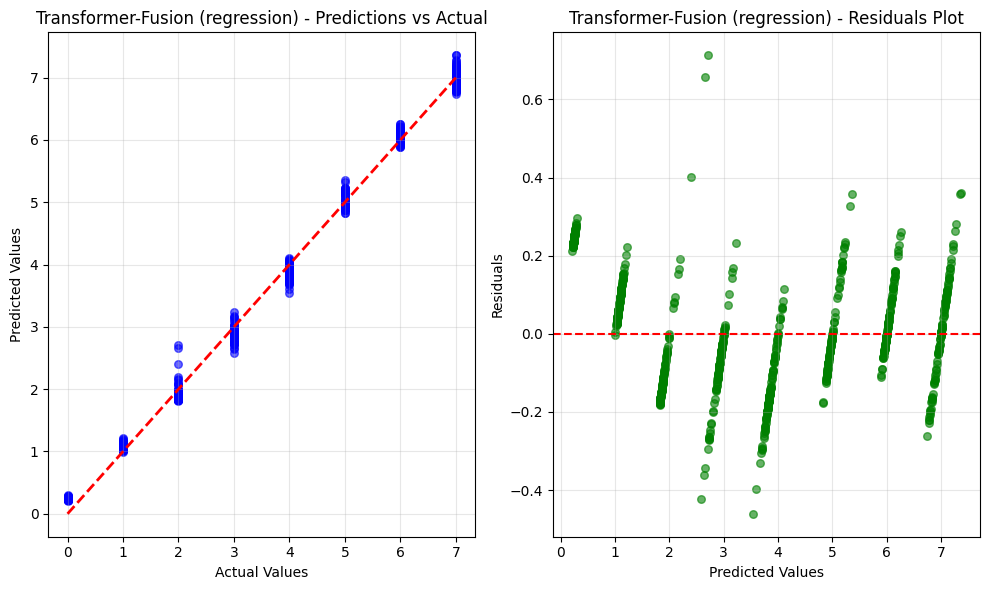


REGRESSION MODEL COMPARISON
             Model    MAE   RMSE MAPE (%) SMAPE (%) R² Score   Loss
Transformer-Fusion 0.1216 0.1506    3.83%     27.10   0.9957 0.0226

Best regression Model: Transformer-Fusion (MAE: 0.1216)

Comparison plots for regression:


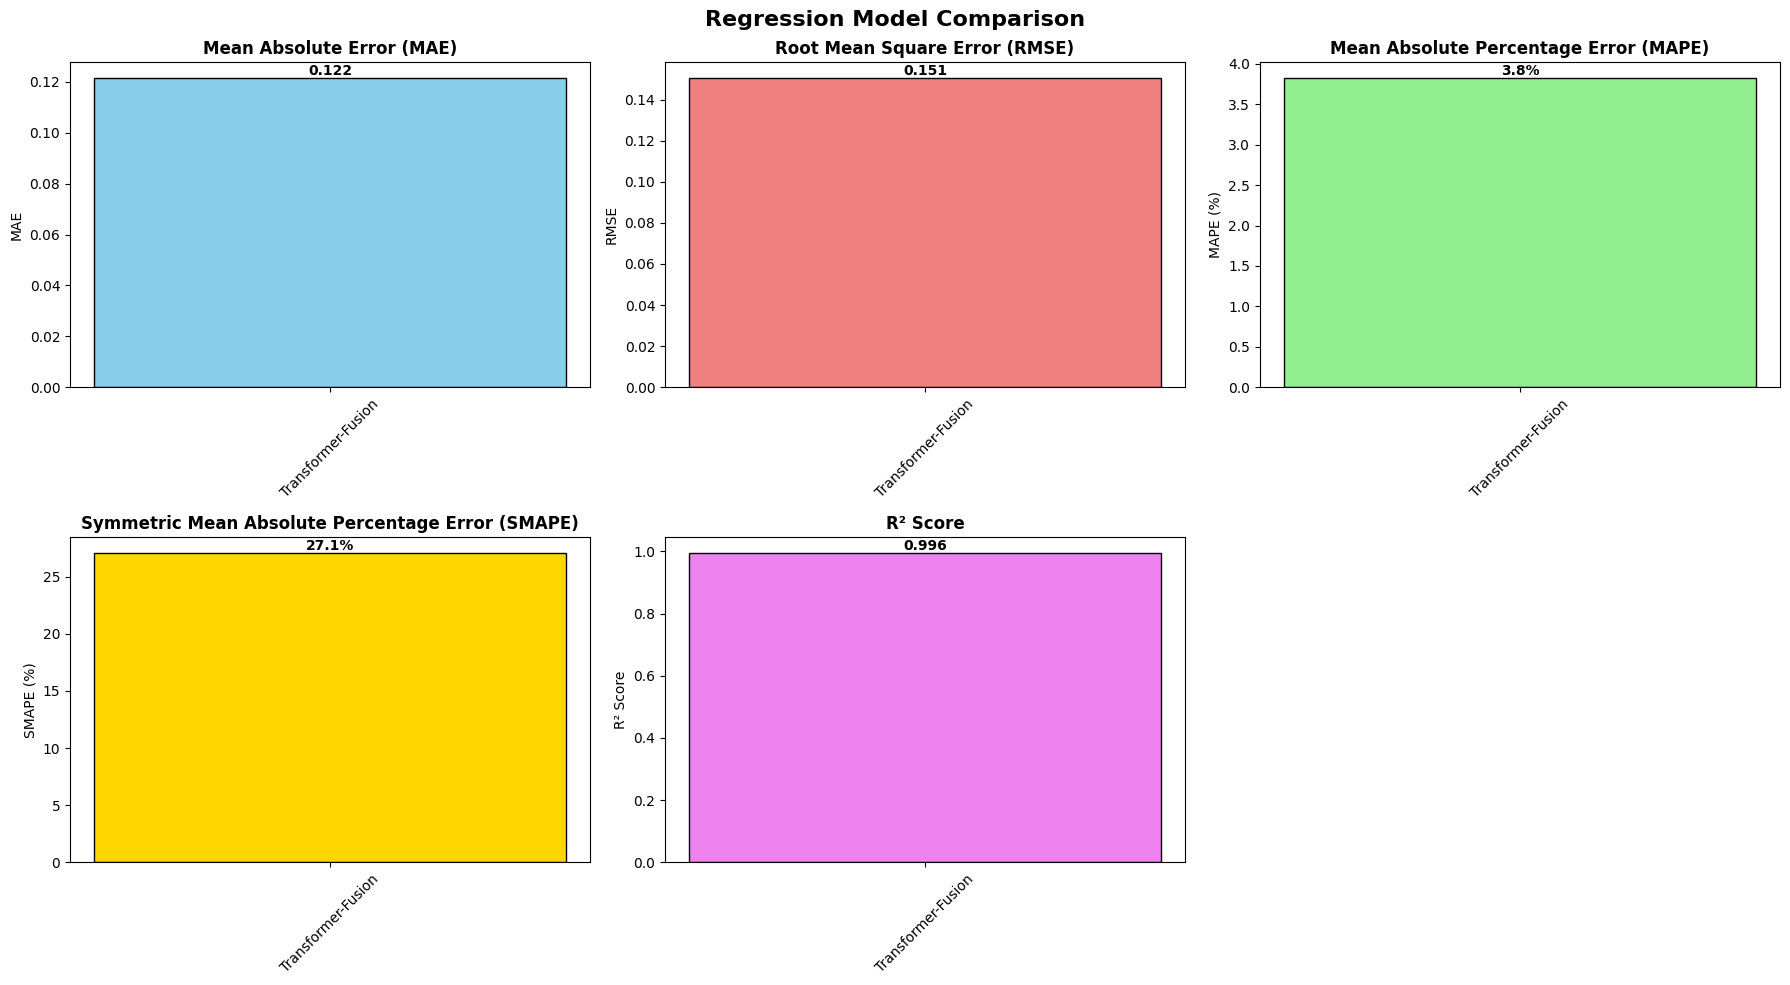

Results saved to: model_comparison_regression_internal_test_results.csv

OVERALL MULTI-TASK SUMMARY (INTERNAL TEST)

REGRESSION Task Summary:
--------------------------------------------------
Best: Transformer-Fusion (MAE: 0.1216)
  • Transformer-Fusion: MAE=0.1216, RMSE=0.1506, R²=0.996

COMPREHENSIVE MULTI-TASK EVALUATION COMPLETE
Tasks evaluated: regression
Test type: Internal (10% split from train dataset)
Test samples: ~800 (10% of 8000)

RECOMMENDATIONS:
• For regression: Use Transformer-Fusion (MAE: 0.1216)


In [36]:
import random

# ============================================
# STEP 1: Tạo internal test loaders trước
# ============================================
print("\n" + "="*80)
print("PREPARING INTERNAL TEST SETS (10% split)")
print("="*80)

if 'all_internal_test_loaders' in globals():
    print("✓ Using test loaders from training session")
    internal_test_loaders = all_internal_test_loaders
else:
    print("⚠️ No test loaders from training - creating new ones")
    internal_test_loaders = {}
    for task_type in ['classification', 'regression']:
        print(f"\nCreating {task_type} internal test loader...")
        train_dataset.task = task_type
        
        _, _, test_loader_temp = create_train_val_test_dataloaders(
            train_dataset, 
            batch_size=BATCH_SIZE, 
            train_split=0.8,
            val_split=0.1,
            test_split=0.1
        )
        
        internal_test_loaders[task_type] = test_loader_temp


# ============================================
# STEP 2: Evaluation với internal test
# ============================================
available_tasks = []
for task in ['classification', 'regression']:
    model_file = os.path.join("/kaggle/working/models", f'transformer_fusion_{task}_best.pth')
    if os.path.exists(model_file):
        available_tasks.append(task)

if not available_tasks:
    print("⚠ No trained models found. Please run training first.")
else:
    print("\n" + "="*80)
    print("COMPREHENSIVE MULTI-TASK EVALUATION (INTERNAL TEST)")
    print("="*80)
    print(f"Available tasks: {', '.join(available_tasks)}")
    print(f"Test split: 10% internal (from train dataset)")
    
    all_task_results = {}
    
    for current_task in available_tasks:
        print(f"\n" + "="*70)
        print(f"EVALUATING {current_task.upper()} MODELS")
        print("="*70)
        
        TASK = current_task
        
        # ✅ Sử dụng internal test loader
        test_loader = internal_test_loaders[TASK]
        
        models = {
            'Transformer-Fusion': TransformerFusionModel(csi_length=CSI_LENGTH, num_classes=NUM_CLASSES, task=TASK).to(device)
        }
        
        model_files = {
            'Transformer-Fusion': os.path.join("/kaggle/working/models", f'transformer_fusion_{TASK}_best.pth')
        }
        
        evaluation_results = {}
        
        for model_name, model in models.items():
            model_file = model_files[model_name]
            is_trained = False
            
            try:
                if os.path.exists(model_file):
                    model.load_state_dict(torch.load(model_file, map_location=device))
                    print(f"✓ Loaded trained weights: {model_name}")
                    is_trained = True
                else:
                    print(f"⚠ No trained weights: {model_name} (using random initialization)")
            except Exception as e:
                print(f"✗ Error loading {model_name}: {e}")
            
            results = evaluate_model(model, test_loader, model_name, task=TASK, verbose=is_trained)
            evaluation_results[model_name] = results
            
            # --- SAMPLE PREDICTIONS ---
            if 'predictions' in results and 'targets' in results:
                print(f"\nSample predictions for {model_name} ({TASK}):")
            
                y_true = np.array(results['targets'])
                y_pred = np.array(results['predictions'])
                
                if TASK == 'classification':
                    unique_classes = sorted(set(y_true))
                    for cls in unique_classes:
                        cls_indices = np.where(y_true == cls)[0]
                        if len(cls_indices) == 0:
                            continue
            
                        num_samples = min(10, len(cls_indices))
                        chosen = random.sample(list(cls_indices), num_samples)
                        print(f"\nClass {cls}: showing {num_samples} random predictions")
                        for i, idx in enumerate(chosen):
                            print(f"  [{i+1}] True: {y_true[idx]} | Pred: {y_pred[idx]}")
                else:
                    num_samples = min(20, len(y_pred))
                    indices = random.sample(range(len(y_pred)), num_samples)
                    for i, idx in enumerate(indices):
                        print(f"  [{i+1}] True: {y_true[idx]:.3f} | Pred: {y_pred[idx]:.3f}")
            
            # --- DETAILED ANALYSIS ---
            if is_trained and 'predictions' in results and 'targets' in results:
                print(f"\n--- {model_name} Detailed Analysis ---")
                
                if TASK == 'classification':
                    plot_confusion_matrix(results['targets'], results['predictions'], f"{model_name} ({TASK})")
                    
                    y_true = results['targets']
                    y_pred = results['predictions']
                    unique_classes = sorted(set(y_true))
                    
                    print(f"\nPer-class Performance ({model_name}):")
                    for cls in unique_classes:
                        mask = np.array(y_true) == cls
                        if np.sum(mask) > 0:
                            cls_acc = np.sum((np.array(y_pred)[mask] == cls)) / np.sum(mask) * 100
                            print(f"  Class {cls}: {cls_acc:.1f}% accuracy ({np.sum(mask)} samples)")
                else:
                    plot_predictions_vs_actual(results['targets'], results['predictions'], f"{model_name} ({TASK})", task=TASK)
        
        # --- TASK COMPARISON TABLE ---
        all_task_results[TASK] = evaluation_results
        
        print(f"\n" + "="*60)
        print(f"{current_task.upper()} MODEL COMPARISON")
        print("="*60)
        
        if TASK == 'classification':
            comparison_data = []
            for model_name, results in evaluation_results.items():
                comparison_data.append({
                    'Model': model_name,
                    'Accuracy (%)': f"{results['accuracy']:.2f}",
                    'Precision (%)': f"{results['precision']:.2f}",
                    'Recall (%)': f"{results['recall']:.2f}",
                    'F1-Score (%)': f"{results['f1_score']:.2f}",
                    'Loss': f"{results['loss']:.4f}"
                })
        else:
            comparison_data = []
            for model_name, results in evaluation_results.items():
                mape_display = "N/A" if results['mape'] == float('inf') else f"{results['mape']:.2f}%"
                comparison_data.append({
                    'Model': model_name,
                    'MAE': f"{results['mae']:.4f}",
                    'RMSE': f"{results['rmse']:.4f}",
                    'MAPE (%)': mape_display,
                    'SMAPE (%)': f"{results['smape']:.2f}",
                    'R² Score': f"{results['r2_score']:.4f}",
                    'Loss': f"{results['loss']:.4f}"
                })
        
        comparison_df = pd.DataFrame(comparison_data)
        print(comparison_df.to_string(index=False))
        
        if TASK == 'classification':
            best_model = max(evaluation_results.items(), key=lambda x: x[1]['accuracy'])
            print(f"\nBest {TASK} Model: {best_model[0]} (Accuracy: {best_model[1]['accuracy']:.2f}%)")
        else:
            best_model = min(evaluation_results.items(), key=lambda x: x[1]['mae'])
            print(f"\nBest {TASK} Model: {best_model[0]} (MAE: {best_model[1]['mae']:.4f})")
        
        trained_models = [name for name in models.keys() if os.path.exists(model_files[name])]
        if trained_models:
            print(f"\nComparison plots for {TASK}:")
            plot_comparison_results(evaluation_results, task=TASK)
        
        results_filename = f'model_comparison_{TASK}_internal_test_results.csv'
        comparison_df.to_csv(results_filename, index=False)
        print(f"Results saved to: {results_filename}")
    
    # --- OVERALL SUMMARY ---
    print(f"\n" + "="*80)
    print("OVERALL MULTI-TASK SUMMARY (INTERNAL TEST)")
    print("="*80)
    
    for task in available_tasks:
        print(f"\n{task.upper()} Task Summary:")
        print("-" * 50)
        results = all_task_results[task]
        
        if task == 'classification':
            best_model = max(results.items(), key=lambda x: x[1]['accuracy'])
            print(f"Best: {best_model[0]} ({best_model[1]['accuracy']:.2f}% accuracy)")
            for model_name, model_results in results.items():
                print(f"  • {model_name}: {model_results['accuracy']:.2f}% acc, {model_results['f1_score']:.2f}% F1")
        else:
            best_model = min(results.items(), key=lambda x: x[1]['mae'])
            print(f"Best: {best_model[0]} (MAE: {best_model[1]['mae']:.4f})")
            for model_name, model_results in results.items():
                print(f"  • {model_name}: MAE={model_results['mae']:.4f}, RMSE={model_results['rmse']:.4f}, R²={model_results['r2_score']:.3f}")
    
    print(f"\n" + "="*80)
    print("COMPREHENSIVE MULTI-TASK EVALUATION COMPLETE")
    print("="*80)
    print(f"Tasks evaluated: {', '.join(available_tasks)}")
    print(f"Test type: Internal (10% split from train dataset)")
    
    # ✅ Cập nhật số lượng samples
    total_train_samples = len(train_dataset)
    internal_test_samples = int(total_train_samples * 0.1)
    print(f"Test samples: ~{internal_test_samples} (10% of {total_train_samples})")
    
    print(f"\nRECOMMENDATIONS:")
    for task in available_tasks:
        results = all_task_results[task]
        if task == 'classification':
            best_model = max(results.items(), key=lambda x: x[1]['accuracy'])
            print(f"• For {task}: Use {best_model[0]} ({best_model[1]['accuracy']:.2f}% accuracy)")
        else:
            best_model = min(results.items(), key=lambda x: x[1]['mae'])
            print(f"• For {task}: Use {best_model[0]} (MAE: {best_model[1]['mae']:.4f})")